In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD


Using TensorFlow backend.


In [37]:
path='/Users/yingyuxuan/Downloads/msk-redefining-cancer-treatment/'
target=pd.read_csv(path+'target.csv')
inputs=pd.read_csv(path+'inputs.csv')

In [38]:
target.drop(columns='Unnamed: 0',inplace=True)
inputs.drop(columns='Unnamed: 0',inplace=True)

In [39]:
target.head()

,target
0,1
1,1
2,1
3,1
4,1


In [40]:
inputs.head()

,Gene,Variation,cleaned_text
0,PRDM1,Deletion,prdm1/blimp-1 master regul plasma-cel differen...
1,BAP1,Deletion,small fraction asbestos-expos individu develop...
2,TSC1,V220F,along-stand problem oncolog variabl treatment ...
3,VHL,S65A,mutat hotspot indic select pressur across popu...
4,CARM1,S217C,coactivator-associ arginin methyltransferas 1 ...


In [41]:
combined_text=[inputs.Gene[i]+inputs.Variation[i]+inputs.cleaned_text[i] for i in range(len(inputs))]

In [42]:
inputs.Gene.shape

(9520,)

In [43]:
len(combined_text)

9520

In [45]:
#train test split dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(combined_text, target, test_size=.2, random_state=0)

In [46]:
# Create a function for vectorize text data
from sklearn.feature_extraction.text import CountVectorizer
def vectorizer(train,test):
    vectorizer=CountVectorizer()
    new_train=vectorizer.fit_transform(train)
    new_test=vectorizer.transform(test)
    return new_train,new_test

In [47]:
X_train,X_test=vectorizer(x_train,x_test)

In [48]:
Y_train=to_categorical(y_train.target)
Y_test=to_categorical(y_test.target)

# Deep Learning

In [88]:
def history_model(X_train, Y_train,X_test, Y_test):

    #Before we build our model, we need to know the input dimension of our feature vectors.
    input_dim = X_train.shape[1] 
    # Add layers one by one in order 
    model = Sequential()
    model.add(keras.layers.Dense(60, input_dim=input_dim, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(60))
    model.add(keras.layers.Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    #specify the optimizer and the loss function.
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    #Give an overview of the model and the number of parameters available for training:
    model.summary()
    # # fit the mode
    history = model.fit(X_train, Y_train,epochs=55, verbose=2,
                    validation_data=(X_test, Y_test),batch_size=50)
    return history, model

In [89]:
history, model=history_model(X_train, Y_train,X_test, Y_test)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 60)                8026980   
_________________________________________________________________
dense_20 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                610       
Total params: 8,031,250
Trainable params: 8,031,250
Non-trainable params: 0
_________________________________________________________________
Train on 7616 samples, validate on 1904 samples
Epoch 1/55
 - 24s - loss: 1.0795 - accuracy: 0.6704 - val_loss: 0.7128 - val_accuracy: 0.7495
Epoch 2/55
 - 24s - loss: 0.5433 - accuracy: 0.8200 - val_loss: 0.7094 - val_accuracy: 0.7747
Epoch 3/55
 - 23s - loss: 0.4648 - accuracy: 0.8477 - val_loss: 0.6121 - val_accuracy: 0.8099
Epoch 4/55
 - 23s - loss: 0.4079 - accuracy

Text(0.5, 1.0, 'Accuracy')

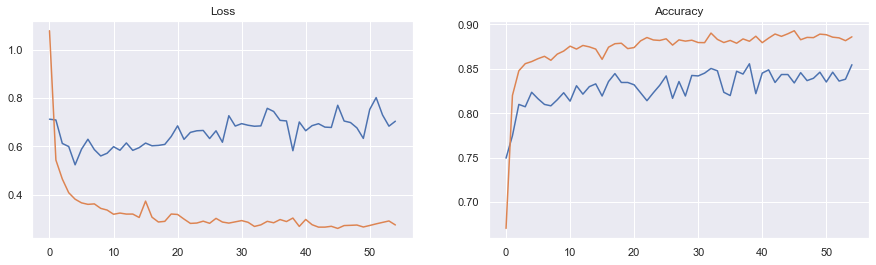

In [90]:
plt.figure(figsize=(15,4))
# Loss
plt.subplot(1,2,1)
plt.plot(list(range(len(history.history['val_loss']))),history.history['val_loss'])
plt.plot(list(range(len(history.history['loss']))),history.history['loss'])
plt.title('Loss')
# accuracy
plt.subplot(1,2,2)
plt.plot(list(range(len(history.history['val_accuracy']))),history.history['val_accuracy'])
plt.plot(list(range(len(history.history['accuracy']))),history.history['accuracy'])
plt.title('Accuracy')


In [91]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score,make_scorer
from sklearn.metrics import confusion_matrix
def NN_results(history,model,x_train,x_test):
    #prediction
    nn_train_pre=model.predict_classes(x_train)
    nn_test_pre=model.predict_classes(x_test)
    # Use accuracy_score function to get the accuracy
    print("Accuracy Score - train data:",accuracy_score(nn_train_pre, y_train))
    print("Accuracy Score - test data:",accuracy_score(nn_test_pre, y_test))
    print('=================================================================')
    #calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score( y_test,nn_test_pre,average='weighted')
    nn_f1_score_train=f1_score(y_train,nn_train_pre,average='weighted')
    print("Train data f1 score:{}".format(nn_f1_score_train))
    print("Test data f1 score:{}".format(nn_f1_score_test ))
    print('=================================================================')
    print(confusion_matrix(y_test, nn_test_pre))
    return nn_train_pre,nn_test_pre
          

In [92]:
nn_train_pre,nn_test_pre=NN_results(history,model,X_train,X_test)

Accuracy Score - train data: 0.8979779411764706
Accuracy Score - test data: 0.854516806722689
Train data f1 score:0.8981466867834812
Test data f1 score:0.8529348253781612
[[138   0   2  14  24  10   1   0   0]
 [  1 160   0   0   3   1  29   0   0]
 [  0   0 181   0   1   3   0   0   0]
 [ 15   0  29 116  13   3   4   0   0]
 [  6   2  12   0 161  16   9   0   4]
 [  4   1   1   0   5 183   3   0   0]
 [  6  19  25   0   9   2 319   0   0]
 [  0   0   0   0   0   0   0 163   0]
 [  0   0   0   0   0   0   0   0 206]]
